## 5x5 Grid World
### Monte Carlo Method 를 적용하여 5x5 Grid World 에 대한 Q함수를 시각화하고 및 policy 를 구하라.
#### (1) 파라메터 𝜀 을 변경하며 결과 비교
#### (2) 파라메터 𝛼 를 변경하며 결과 비교

### GridWorld class

In [22]:
import numpy as np
import common.gridworld5_render as render_helper

class GridWorld:
    def __init__(self):
        self.action_space = [0, 1, 2, 3]  # 행동 공간(가능한 행동들)
        self.action_meaning = {  # 행동의 의미
            0: "UP",
            1: "DOWN",
            2: "LEFT",
            3: "RIGHT",
        }

        self.reward_map = np.array(  # 보상 맵(각 좌표의 보상 값)
            [[0, 0, 0, -1.0, 1.0],
             [0, 0, 0, 0, 0],
             [0, None, None, 0, 0],
             [0, 0, 0, 0, -1.0],
             [0, 0, 0, 0, 0]
             ]
        )

        self.goal_state = (0, 4)    # 목표 상태(좌표)
        self.wall_state = [(2, 1), (2,2)]   # 2,1 2,2 # 벽 상태(좌표)
        self.start_state = (4, 0)   # 시작 상태(좌표)
        self.agent_state = self.start_state   # 에이전트 초기 상태(좌표)

    @property
    def height(self):
        return len(self.reward_map)

    @property
    def width(self):
        return len(self.reward_map[0])

    @property
    def shape(self):
        return self.reward_map.shape

    def actions(self):
        return self.action_space

    def states(self):
        for h in range(self.height):
            for w in range(self.width):
                yield (h, w)

    def next_state(self, state, action):
        # 이동 위치 계산
        action_move_map = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        move = action_move_map[action]
        next_state = (state[0] + move[0], state[1] + move[1])
        ny, nx = next_state

        # 이동한 위치가 그리드 월드의 테두리 밖이나 벽인가?
        if nx < 0 or nx >= self.width or ny < 0 or ny >= self.height:
            next_state = state
        elif next_state == self.wall_state[0] or next_state == self.wall_state[1]:
            next_state = state

        return next_state  # 다음 상태 반환

    def reward(self, state, action, next_state):
        if self.reward_map[next_state] == None:
            return 0

        return self.reward_map[next_state]

    def reset(self):
        self.agent_state = self.start_state
        return self.agent_state

    def step(self, action):
        state = self.agent_state
        next_state = self.next_state(state, action)
        reward = self.reward(state, action, next_state)
        done = (next_state == self.goal_state)

        self.agent_state = next_state
        return next_state, reward, done

    def render_v(self, v=None, policy=None, print_value=True):
        renderer = render_helper.Renderer(self.reward_map, self.goal_state,
                                          self.wall_state)
        renderer.render_v(v, policy, print_value)

    def render_q(self, q=None, print_value=True):
        renderer = render_helper.Renderer(self.reward_map, self.goal_state,
                                          self.wall_state)
        renderer.render_q(q, print_value)


### test code

In [23]:
env = GridWorld()

print(env.height)
print(env.width)
print(env.shape)

5
5
(5, 5)


In [24]:
for action in env.actions():
    print(action)

print('====================')

for state in env.states():
    print(state)

0
1
2
3
(0, 0)
(0, 1)
(0, 2)
(0, 3)
(0, 4)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(1, 4)
(2, 0)
(2, 1)
(2, 2)
(2, 3)
(2, 4)
(3, 0)
(3, 1)
(3, 2)
(3, 3)
(3, 4)
(4, 0)
(4, 1)
(4, 2)
(4, 3)
(4, 4)


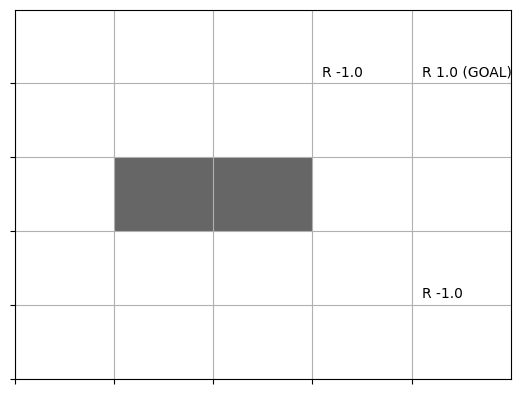

In [25]:
env = GridWorld()
env.render_v()


### Policy Evaluation

In [26]:
from collections import defaultdict
import numpy as np

class RandomAgent:
    def __init__(self):
        self.gamma = 0.9
        self.batch_size = 4

        random_actions = {0: 0.25, 1:0.25, 2:0.25, 3:0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.V = defaultdict(lambda: 0)
        self.cnts = defaultdict(lambda: 0)
        self.memory = []

    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)

    def add(self, state, action, reward):
        data = [state, action, reward]
        self.memory.append(data)

    def reset(self):
        self.memory.clear()

    def eval(self):
        G = 0
        for data in reversed(self.memory):  # 역방향으로(reversed) 따라가기
            state, action, reward = data
            G = self.gamma * G + reward
            self.cnts[state] += 1
            self.V[state] += (G - self.V[state]) / self.cnts[state]

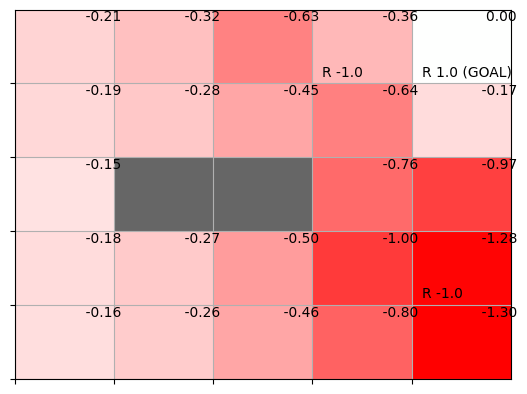

In [27]:
env = GridWorld()
agent = RandomAgent()

episodes = 1000
for episode in range(episodes):
    state = env.reset()
    agent.reset()

    while True:
        action = agent.get_action(state)       # 행동 선택
        next_state, reward, done = env.step(action)  # 행동 수행

        agent.add(state, action, reward)       # (상태, 행동, 보상) 저장

        if done:  # 목표에 도달 시
            agent.eval()  # 몬테카를로 방식으로 가치 함수 갱신
            break         # 다음 에피소드 시작

        state = next_state


env.render_v(agent.V)

### Policy control

In [30]:
import numpy as np
from collections import defaultdict
#from common.gridworld import GridWorld

def greedy_probs(Q, state, epsilon=0, action_size=4):
    qs = [Q[(state, action)] for action in range(action_size)]
    max_action = np.argmax(qs)

    base_prob = epsilon / action_size
    action_probs = {action: base_prob for action in range(action_size)}
    action_probs[max_action] += (1 - epsilon)
    return action_probs


class McAgent:
    def __init__(self, gamma=0.9, epsilon=0.1, alpha=0.1, action_size=4):
        self.gamma = gamma
        self.epsilon = epsilon
        self.alpha = alpha
        self.action_size = action_size

        random_actions = {0:0.25, 1:0.25, 2:0.25, 3:0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.Q = defaultdict(lambda: 0)

        self.memory = []

    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)

    def add(self, state, action, reward):
        data = (state, action, reward)
        self.memory.append(data)

    def reset(self):
        self.memory.clear()

    def update(self):
        G = 0
        for data in reversed(self.memory):
            state, action, reward = data
            G = self.gamma * G + reward
            key = (state, action)

            self.Q[key] += (G-self.Q[key]) * self.alpha
            self.pi[state] = greedy_probs(self.Q, state, self.epsilon)



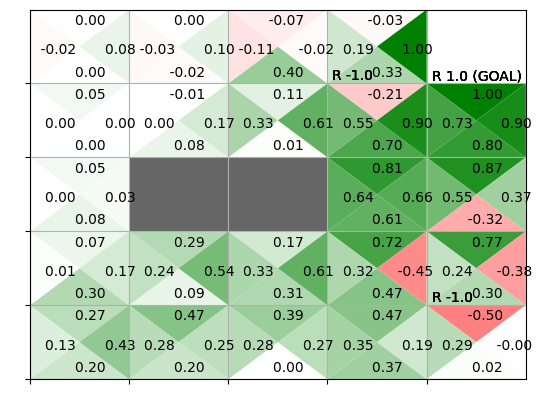

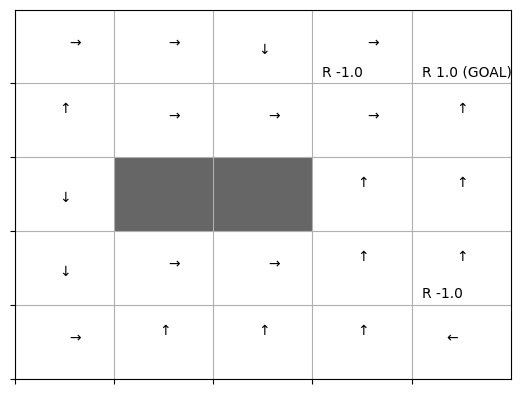

In [33]:
env = GridWorld()

# Parameters
gamma = 0.9
epsilon = 0.1
alpha = 0.1
action_size = 4
agent = McAgent(gamma, epsilon, alpha, action_size)

episodes = 10000
for episode in range(episodes):
    state = env.reset()
    agent.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.add(state, action, reward)
        if done:
            agent.update()
            break

        state = next_state

env.render_q(agent.Q)

### epsilon, alpha 값에 따른 결과 비교

Epsilon=0.1, Alpha=0.1


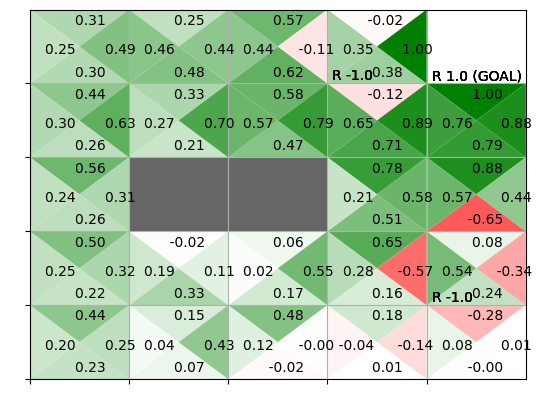

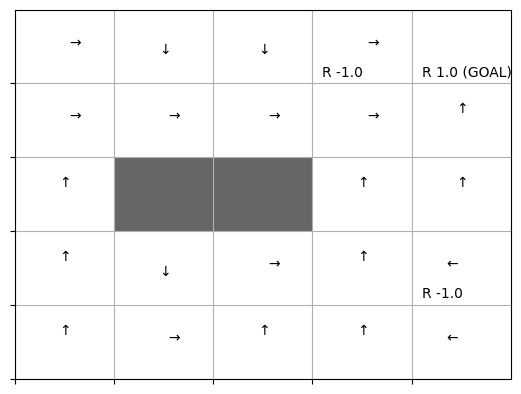

Epsilon=0.1, Alpha=0.3


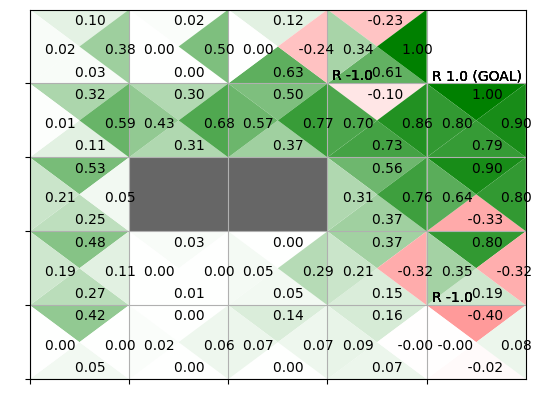

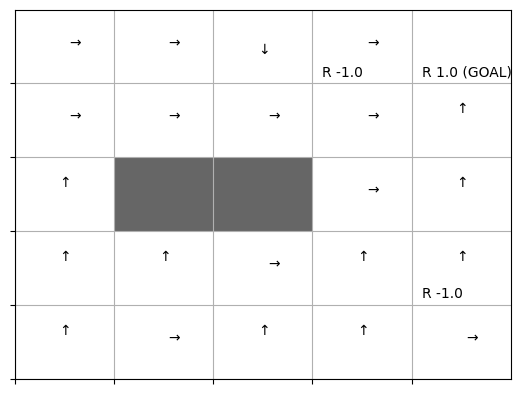

Epsilon=0.1, Alpha=0.5


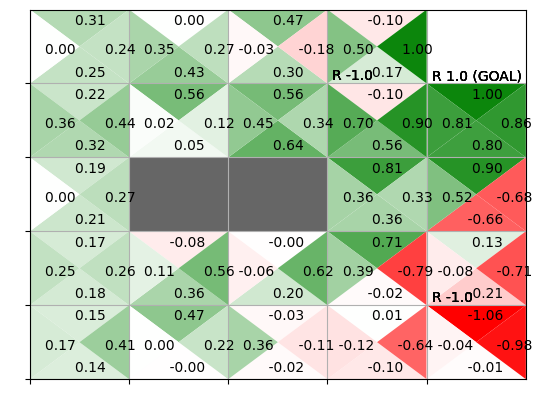

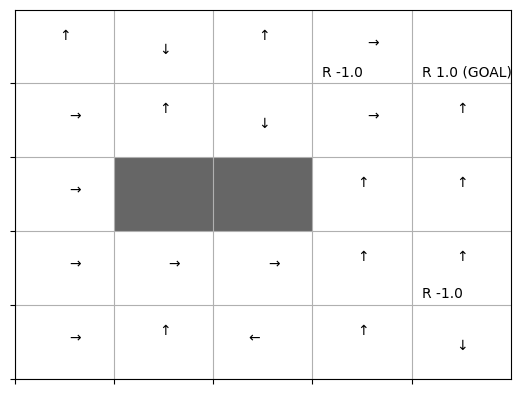

Epsilon=0.3, Alpha=0.1


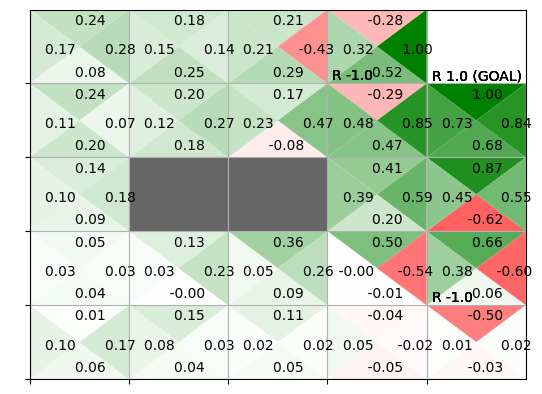

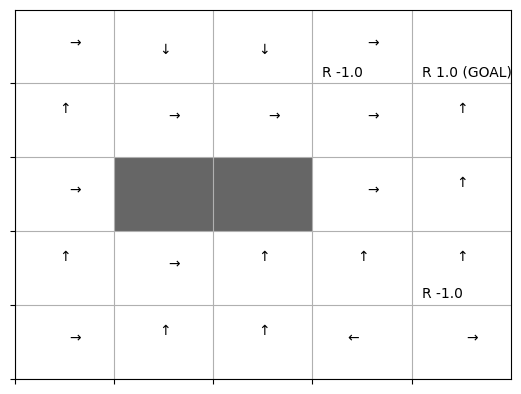

Epsilon=0.3, Alpha=0.3


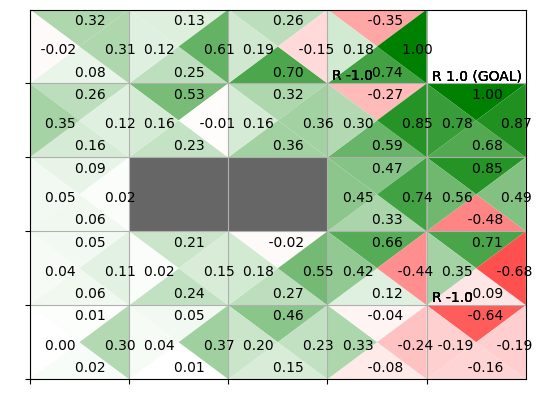

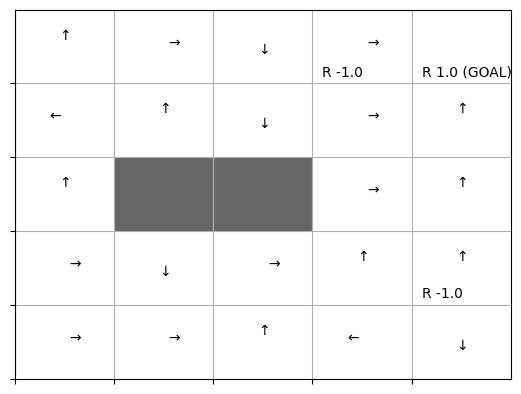

Epsilon=0.3, Alpha=0.5


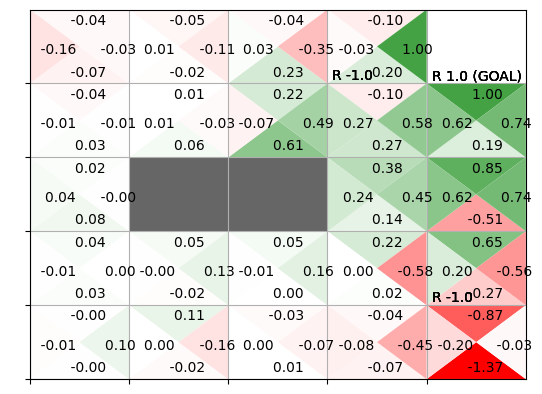

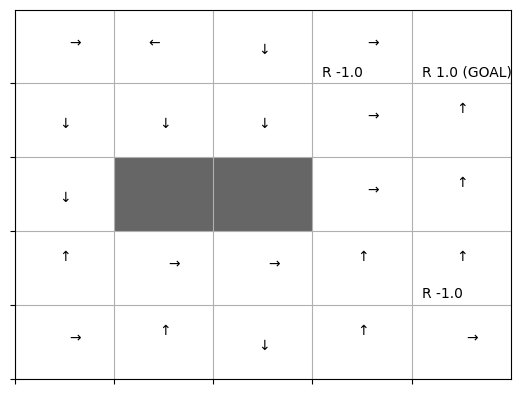

Epsilon=0.5, Alpha=0.1


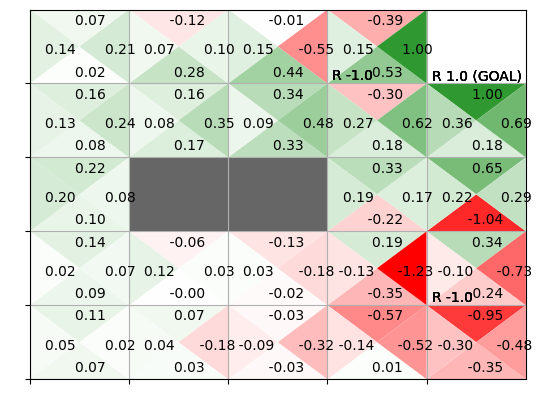

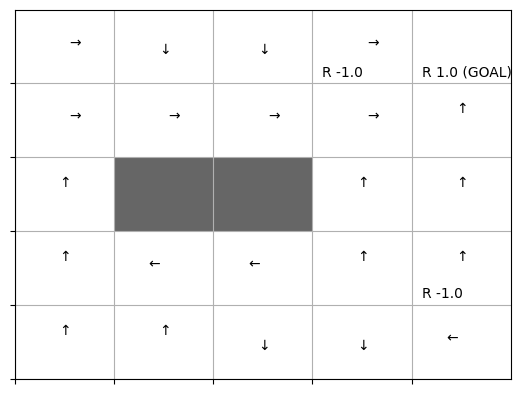

Epsilon=0.5, Alpha=0.3


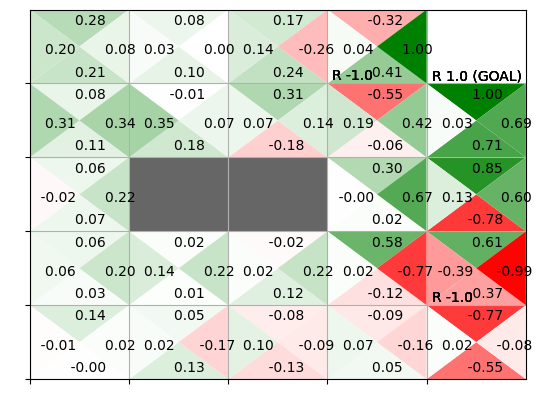

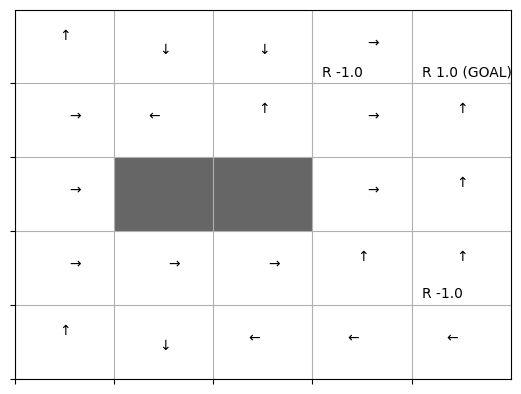

Epsilon=0.5, Alpha=0.5


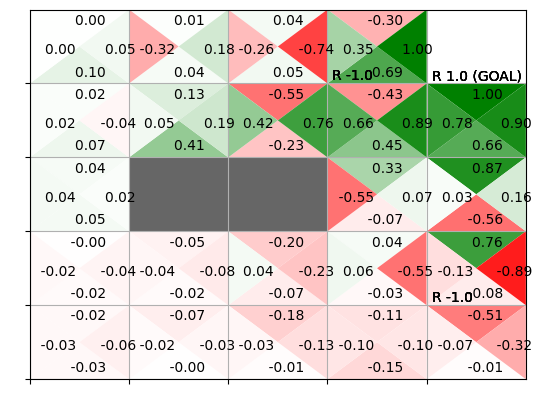

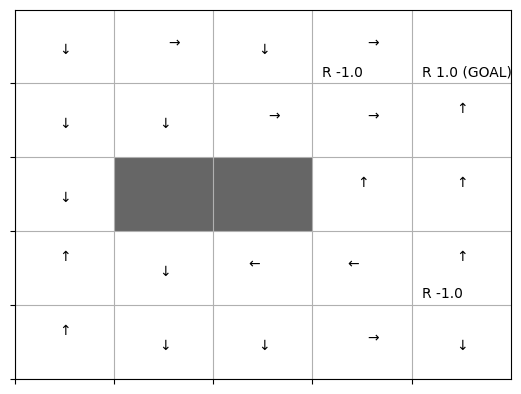

In [34]:
# Parameters
epsilon_values = [0.1, 0.3, 0.5]
alpha_values = [0.1, 0.3, 0.5]
episodes = 10000

for epsilon in epsilon_values:
    for alpha in alpha_values:
        env = GridWorld()
        agent = McAgent(gamma=0.9, epsilon=epsilon, alpha=alpha, action_size=4)

        for episode in range(episodes):
            state = env.reset()
            agent.reset()

            while True:
                action = agent.get_action(state)
                next_state, reward, done = env.step(action)
                agent.add(state, action, reward)

                if done:
                    agent.update()
                    break

                state = next_state

        # Visualization
        print(f"Epsilon={epsilon}, Alpha={alpha}")
        env.render_q(agent.Q)


In [35]:
print('--')

--
